So you've got a clean dataset, you've picked the machine learning model you're going to use, you've trained your model and you've got some results. They may even look pretty good! But how do you know if your model is the best that it can be? One way you can try to improve a model is through **hyperparameter tuning**. 

> **Hyperparameter:** Hyperparameters are the "settings" in your model. What the hyperparameters will be specifically depends on the type of model you're training. Some examples of hyperparameters include the number of training rounds in XGBoost or the learning rate in a neural network. In R, if you don't specify what specific hyperparameters in you should be, then your model will be trained with the default hyperparameters specified by whichever function you're using to train your model--and they may not be the best for your specific problem.

Of course, you can try to pick the best values for your hyperparameters by just coming up with a bunch of random values that might work, training a model for each of those values and then picking the one with the highest accuracy. But that isn't a very systematic approach, and hard to automate (especially if you're tuning more than one hyperparameter at a time!)

Luckily for us, R has the caret package, which is designed to help you test different hyperparameter values for a specific model in a fast, systematic way. In this tutorial, we're going to learn how to use caret to select the best-performing hyperparameters for a specific model.

____

### What will I learn?

By the time you finish this tutorial, you will learn:

* How to prepare your data
* How to train a baseline model
* How to train a tuned model using caret
* How to compare models
    
### What do I need to know before I get started?

You may find some of the discussion here hard to understand if you don't have a basic familiarity with the R language before you begin. I would recommend [this series of lessons](https://www.kaggle.com/rtatman/getting-started-in-r-first-steps/) if you've never used R or never programmed before.

### What will I need to do?

As you work through this tutorial, you'll have a number of exercises to complete. You are of course free to fork this notebook and do them here, but the easiest option is to fork a version of [this workbook for this lesson](https://www.kaggle.com/rtatman/picking-the-best-model-with-caret-workbook).

____

## Table of Contents
____
* [Clean our dataset](#Clean-our-dataset)
* [Split data into testing and training set](#Split-data-into-testing-and-training-set)
* [Train an untuned model](#Train-an-untuned-model)
* [Tuning with caret](#Tuning-with-caret)
* [Comparing our models](#Comparing-our-models)


# Setting up our environment
___

First, we're going to need to get our R environment set up. I'll need to load in the libraries we'll use and our dataset.

In [1]:
# libraries we'll need
library(tidyverse) # utility functions
library(caret) # hyperparameter tuning
library(randomForest) # for our model
library(Metrics) # handy evaluation functions

# read in our data
player_statistics <- read_csv("../input/PUBG_Player_Statistics.csv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.2.0     
✔ readr   1.2.0          ✔ forcats 0.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Parsed with column specification:
cols(
  .default = col_double(),
  player_name = col_character()
)
See spec(...) for full column specifications.


## Your turn!
___

In [your workbook for this lesson](https://www.kaggle.com/rtatman/picking-the-best-model-with-caret-workbook), your environment has been set up for you. :)

# Clean our dataset
___

For this tutorial, I'm going to be trying to predict how often players playing a video game called "PLAYERUNKNOWN'S BATTLEGROUNDS" will win when they play by themselves (i.e. without a team). Before we train our model, however, we'll need to clean our dataset. Why? Two reasons:

* **To get high-quality predictions.** We don't want to try to predict how often a particular player will win by looking at info about how often a particular player wins. We'd get a very accurate model, sure, but it won't extend well to new players. This is sort of like trying to predict what gift someone gave you by peeking at the gift before it's time to open it. You'll be able to make an accurate prediction, but it won't help you very much next time they give you a gift.
* **To cut down on training time.** Adding additional variables increases the amount of time it will take to train our model. Removing unhelpful variables we don't want to use will help our model train more quickly.

Since we're interested in solo play specifically, we can select only columns with information about players when they are playing solo.

In [2]:
# only information on solo plays
player_statistics <- player_statistics %>%
    select(starts_with("solo"))

# check out the first few rows
head(player_statistics)

solo_KillDeathRatio,solo_WinRatio,solo_TimeSurvived,solo_RoundsPlayed,solo_Wins,solo_WinTop10Ratio,solo_Top10s,solo_Top10Ratio,solo_Losses,solo_Rating,⋯,solo_RideDistance,solo_MoveDistance,solo_AvgWalkDistance,solo_AvgRideDistance,solo_LongestKill,solo_Heals,solo_Revives,solo_Boosts,solo_DamageDealt,solo_DBNOs
3.14,17.65,18469.14,17,3,0.83,4,23.5,14,1559.78,⋯,27537.53,56461.84,2202.40,2764.50,304.87,33,0,29,4341.06,0
4.41,18.18,33014.86,33,6,0.36,11,33.3,27,1884.53,⋯,117837.74,165706.51,2017.38,5188.69,351.95,60,0,88,12970.39,0
3.60,0.00,4330.44,5,0,0.00,1,20.0,5,1255.92,⋯,7683.20,14023.99,1375.70,3052.50,125.76,5,0,3,1648.82,0
14.00,50.00,13421.82,8,4,0.67,6,75.0,4,1798.70,⋯,30314.83,47894.53,2197.46,3789.35,412.25,8,0,24,6015.57,0
10.50,33.33,9841.04,6,2,0.40,5,83.3,4,1668.67,⋯,22425.36,39161.77,2789.40,3737.56,307.97,12,0,21,3824.89,0
5.73,31.25,22003.22,16,5,0.50,10,62.5,11,2123.32,⋯,60352.12,91395.30,1940.20,3772.01,298.03,22,0,50,6591.15,0


One thing I notice looking at the top few rows is that some columns, like solo_Revives, look like they may only have zeros in them. I want to automatically remove any columns that have the same value for all players because they're not likely to helpful for prediction but will still increase the training time.

In [3]:
# remove empty columns

# make a data frame with the max & min value per column
max_min <- data_frame(max = apply(player_statistics, 2, max),
                      min = apply(player_statistics, 2, min),
                      columns = names(player_statistics))

# vector of useless column names
useless_columns <- max_min$columns[max_min$min == max_min$max]
# add  minus signs so select() will remove them
useless_columns <- paste("-", useless_columns, sep = "")

# remove useless columns
player_statistics <- player_statistics %>%
    select_(.dots = useless_columns )

We also want to remove any variables that will directly tell us about the variable we're trying to predict. Any variable (except for our target variable) that tell us directly about wins or losses can go. 

In [4]:
# remove leaky variables
player_statistics <- player_statistics %>%
    group_by(solo_WinRatio) %>% #use group_by to protect our target variable
    select(-contains("win")) %>% # remove any columns with "win" in the name
    select(-contains("loss")) %>% # remove any columns with "loss" in the name
    ungroup() # remove grouping

Adding missing grouping variables: `solo_WinRatio`


We also want to only use numeric variables, so let's get rid of any rows with na values or columns that aren't numeric.

In [5]:
# numeric data only
player_statistics <- player_statistics %>%
    na.omit() %>% 
    select_if(is.numeric)

Finally, let's check out our smaller, cleaned dataset one final time just to make sure it all looks ok and we haven't made any obvious mistakes. 

In [6]:
# check out our final dataset
str(player_statistics)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	87898 obs. of  42 variables:
 $ solo_WinRatio           : num  17.6 18.2 0 50 33.3 ...
 $ solo_KillDeathRatio     : num  3.14 4.41 3.6 14 10.5 5.73 2.45 2.71 3.68 4.17 ...
 $ solo_TimeSurvived       : num  18469 33015 4330 13422 9841 ...
 $ solo_RoundsPlayed       : num  17 33 5 8 6 16 142 19 44 8 ...
 $ solo_Top10s             : num  4 11 1 6 5 10 34 10 13 4 ...
 $ solo_Top10Ratio         : num  23.5 33.3 20 75 83.3 62.5 23.9 52.6 29.5 50 ...
 $ solo_Rating             : num  1560 1885 1256 1799 1669 ...
 $ solo_BestRating         : num  1416 1861 1267 1765 1617 ...
 $ solo_DamagePg           : num  255 393 330 752 637 ...
 $ solo_HeadshotKillsPg    : num  0.65 1.27 0.6 0.5 1.5 0.69 0.64 0.68 1.02 0.5 ...
 $ solo_HealsPg            : num  1.94 1.82 1 1 2 1.38 1.94 1.53 1.52 1.12 ...
 $ solo_KillsPg            : num  2.59 3.61 3.6 7 7 3.94 2.24 2 3.18 3.12 ...
 $ solo_MoveDistancePg     : num  3321 5021 2805 5987 6527 ...
 $ solo_RoadKillsPg   

All looks good! So we ended up with a final count of 87k observations of 41 variables plus our target variable. Now we're ready to split our data into a testing and training set.

___
## Your turn!

Head over to [your workbook](https://www.kaggle.com/rtatman/picking-the-best-model-with-caret-workbook) and clean the dataset that's been loaded into. In your workbook, you'll be predicting the rating of FIFA players based on their statistics.

# Split data into testing and training set
___

Becuase this is a really big dataset, I'm going to do a pretty weird testing/training split: I'm actually going to use only 20% of our data for training, about 17,000 examples. Usually you'll get more accurate models the bigger that dataset you're training on, but more training data also leads to models taking longer to train.

To split our data, we're going to use the createDataPartition() from the caret package. The function randomly samples the a proportion of the indexes of a vector you pass it. Then you can use those indexes to subset your full dataset into testing and training datasets.

In [7]:
# split data into testing & training
set.seed(1234)

# train/test split
training_indexs <- createDataPartition(player_statistics$solo_WinRatio, p = .2, list = F)
training <- player_statistics[training_indexs, ]
testing  <- player_statistics[-training_indexs, ]

Finally, I'm going to pull out only the input variables and convert them to a matrix to pass to our randomForests model.

In [8]:
# get predictors
predictors <- training %>% select(-solo_WinRatio) %>% as.matrix()
output <- training$solo_WinRatio

___
## Your turn!

Head over to [your workbook](https://www.kaggle.com/rtatman/picking-the-best-model-with-caret-workbook) and try your hand at splitting data into testing and training sets.

#  Train an untuned model
___

Because we're trying to predict a numeric variable (how often a given player will win) rather than categorize players (e.g. high win-rate vs. low win-rate players), we're going to treat this as a regression problem rather than a classification problem. We're going to model it using random forests. Random forests have two main parameters that you can change, ntree and mtry.

* **ntree**: This is the total number of trees in your final ensemble model.
* **mtry**: The number of features to use to build each tree.

We're only going to be using caret to tune mtry, not ntrees. Why? It has to do with how the overall error of the model changes as we change these parameters. Caret works by finding the parameter value where we have the lowest overall error.  Some features (like ntrees) will usually continue to reduce overall error as you increase them. You can see an example of this in [this 2015 paper](http://surveyinsights.org/?p=5108) by Buskirk & Kolenikov:

![](https://preview.ibb.co/iDRspm/Buskirk_Kolenikov_Appendix_Errorversus_Trees.png)


Notice that the error drops off sharply near the beginning but then continues to very gently trend downwards. Since increasing the number of trees increases the amount of time it takes to train your model and makes it more likely that you're going to overfit to your data, picking ntrees by the smallest overall error doesn't make sense. (It would probably recommend an infinite number of trees!) Instead, you want to pick a value near the "elbow", where you have high accuracy but aren't training more trees than you need to. In practice, most random forest models will have good performance with a number of trees somewhere between 50 and 500.

On the other hand, changing the mtry parameter will usually lead to a u-shaped error pattern: both very high and very low values will have higher error rates and somewhere in the middle will be a sweetspot where the error rate is lower. This is exactly the type of parameter that it makes sense to tune using caret!

> **How will I know whether my parameter will respond well to tuning?** In this case, the caret authors (Max Kuhn and the rest of the contributers) have your back. For most types of models, caret will already know which parameters it makes sense to tune and ignore the others. In the case of random forests, for example, you can't actually tune ntrees using caret and it will automatically tune mtry for you. Handy! :)

With that in mind, let's start by training just a basic random forest model with the default value of mtry. In the randomForest package, the default value is the total number of variables divided by three, and then rounded down to the nearest whole number.


In [9]:
# train a random forest model
model <- randomForest(x = predictors, y = output,
                      ntree = 50) # number of trees

# check out the details
model


Call:
 randomForest(x = predictors, y = output, ntree = 50) 
               Type of random forest: regression
                     Number of trees: 50
No. of variables tried at each split: 13

          Mean of squared residuals: 11.60515
                    % Var explained: 88.41

The output of the model tells us about the qualities of the model we've trained and how good it was at capturing the variation in our training data. 

**Qualities of the model**

* *Call*: This just tell us what we passed into the randomForest function in the first place.
* *Type of random forest*: This is automatically determined based on your target variable y. Since our target variable is not a factor, we've trained a regression tree.
* *Number of trees*: We specified this manually.
* *No. of variables tried at each split*: This is same thing as mtry. Here it's been automatically determined based on the number of features divided by three. (This is what we're going to tune in just a moment!)

**How well does our model explain our training data?**

* *The mean of the squared residuals*: This tells us how well our model described the training set. A “residual” is how much our model's prediction was off for a single data point. The mean of the squared residuals tells us how off we were for every data point in the whole training set. In general, lower numbers are better, but a very low value may mean your model is over-fit. 
* *Percent of the variance explained*: This is the same thing as 100 time the R-squared value for this model. 100 would mean that our model was a perfect fit (e.g. explains all the variance in your training data) while 0 would mean that our model doesn't explain any of the variance in our training data. In general, higher is better, but if this is very close to 100 you may have overfit your model.

Now that we've trained our baseline model, let's check out what our error is on out held-out testing data. We're going to use a measure called "root mean squared error" or "rmse" for this. To get rmse, you first take the square of how off we are for each data point. (That will mean that larger errors will increase our overall error measurement more). Then you find the average of all the squared errors and then take the square root of that. We'll use the rmse() function to calculate it. 

> **Tip**: Because it scales based on the number of points in your dataset, it doesn't usually make sense to compare rmse for models trained on different datasets.

Let's see what our untuned model's error is on our held-out testing data.

In [10]:
# check out our model's root mean squared error on the held out test data
rmse(predict(model, testing), testing$solo_WinRatio)

[1] 3.322332

By itself, that doesn't mean much. But now that we have a base error, let's see if we can train a more accurate model by tuning mtry!

___
## Your turn!

Head over to [your workbook](https://www.kaggle.com/rtatman/picking-the-best-model-with-caret-workbook) and train a baseline random forest model to predict what a player's rating will be based on their statistics.

# Tuning with caret
___

Tuning our model is pretty simple, it will just take awhile. That makes sense: we do need to train a bunch of different models to see which model is better, after all. 

In [11]:
# use caret to pick a value for mtry
tuned_model <- train(x = predictors, y = output,
                     ntree = 5, # number of trees (passed ot random forest)
                     method = "rf") # random forests

print(tuned_model)

Random Forest 

17581 samples
   41 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 17581, 17581, 17581, 17581, 17581, 17581, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    5.658717  0.6707880  2.724625
  21    3.659766  0.8621539  1.717330
  41    3.271572  0.8894731  1.308294

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 41.


As you can see, caret picked 41 as the best mtry value. That means that this model was most accurate when we used all the variables for prediction. We can see this very clearly if we plot the rmse for each of the values it tried by passing our tuned model right to ggplot. 

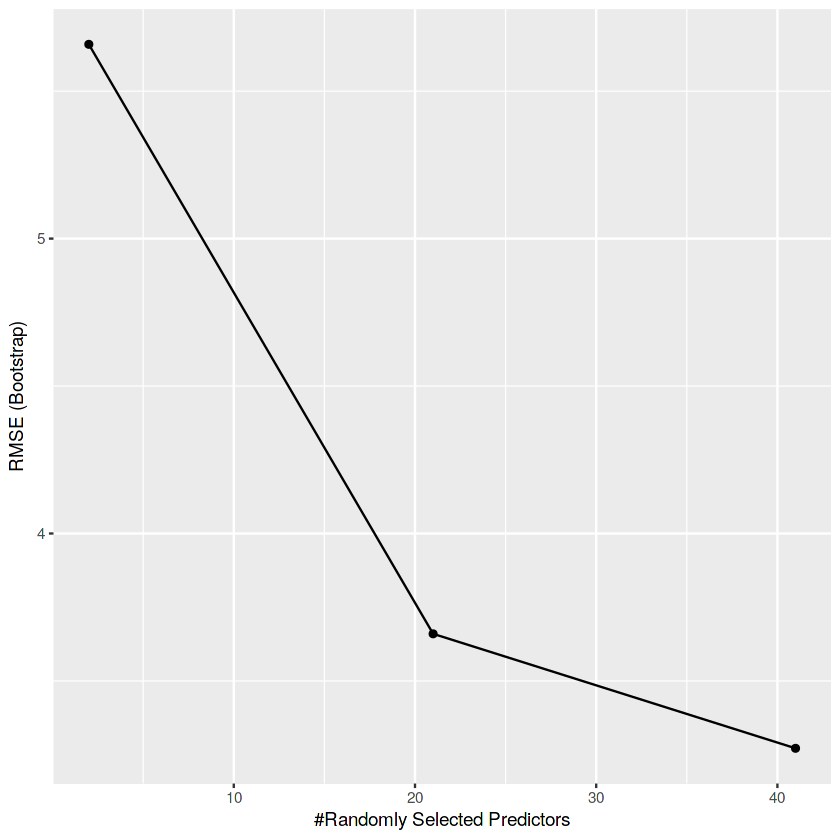

In [12]:
# plot the rmse for various possible training values
ggplot(tuned_model)

As we can tell from looking at our plot, our overall rmse went down as we increased the number of variables we used, and was lowest when we used 41 variables. In this case, the most accurate model was one that used all of the variables in our dataframe.

___
## Your turn!

Head over to [your workbook](https://www.kaggle.com/rtatman/picking-the-best-model-with-caret-workbook) and train a tuned version of the model you built earlier.

# Comparing our models
____

So how does our tuned model stack up to our original baseline model? Let's check their accuracy on our test data.

In [13]:
print("base model rmse:")
print(rmse(predict(model, testing), testing$solo_WinRatio))

print("tuned model rmse:")
print(rmse(predict(tuned_model$finalModel, testing), testing$solo_WinRatio))

Looks like our tuned model has a lower overall error rate! If it didn't, it might mean that our model was overfit (that is, really accurate on the training data, to the point where it didn't generalize well to unseen data).

We can also compare what each model selected as the most important features. In this case, I'm going to look at the top five features for each model. In these plots, "IncNodePurity" is a measure of how important each feature is. A larger value means that feature was more important. 

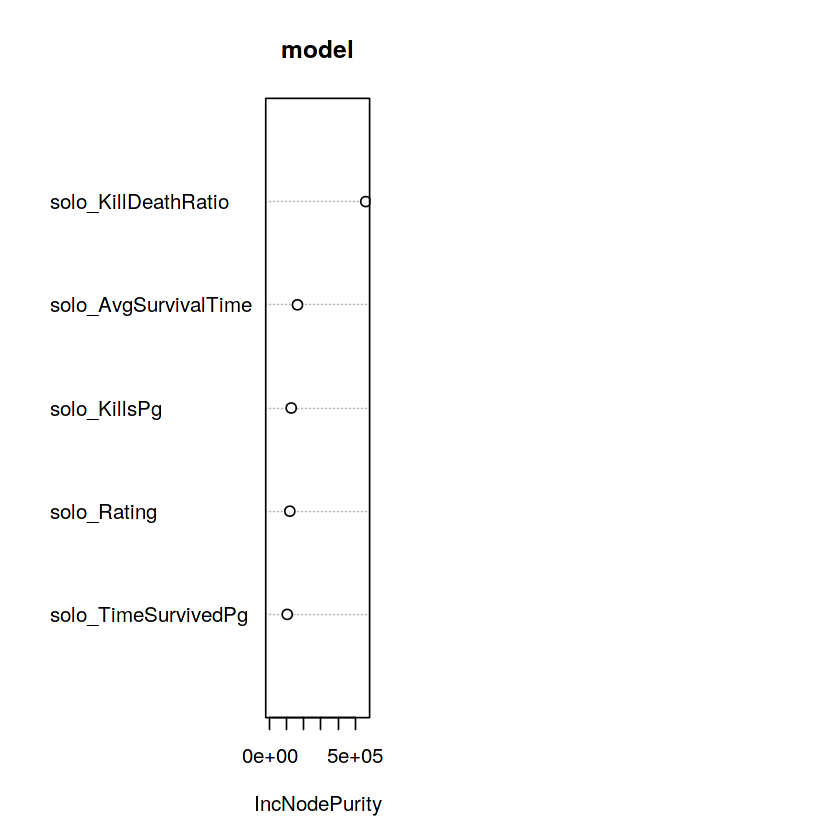

In [13]:
# plot both plots at once
par(mfrow = c(1,2))

varImpPlot(model, n.var = 5)
# varImpPlot(tuned_model$finalModel, n.var = 5)

___
## Your turn!

Head over to [your workbook](https://www.kaggle.com/rtatman/picking-the-best-model-with-caret-workbook) and compare your baseline and tuned model. Which was more accurate? Why do think that might have been? Which features are more important in each model?

# Conclusion
___

And that's all there is to it! Why not try using caret to tune a different model, like xgboost? You can check out an [R xgboost tutorial here](https://www.kaggle.com/rtatman/machine-learning-with-xgboost-in-r). 

Happy analyzing!